In [1]:
import sys
import random
import hashlib
import matplotlib
import pandas as pd
from geopy.distance import geodesic
sys.path.append('../')
sys.path.append('../../')
import plotly.graph_objects as go
from Resources.mlTracker import *
from Python.Preprocessing.funcs import *
import Python.Private.constants as private_constants
from Python.FeatureEngeeniering.Fresnel.fresnelFeature import *

In [2]:
#Omitiendo warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Colores base
#Diseño base
mClr = designC['cs']
mClr_d2 = plt.get_cmap('cs-d')(2)
sClr1 = designC['nr']
sClr1_d2 = plt.get_cmap('nr-d')(2)
sClr3 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
sClr4 = designC['vr']
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

In [4]:
#Obteniendo token
mapbox_access_token = private_constants.mapbox_access_token

In [5]:
#Leyendo datos
df = pd.read_parquet('../../Data/DataMart/Views/TrainingViews/mg_prepared.parquet')
h_mg = pd.read_parquet('../../Data/DataMart/Alturas/mg_h.parquet')
df.head()

,serialNumber,latitude,longitude,round,fixed_path,FE-Comments,first_jump,ImgName,NoCommunicatingDays,numberOfNeighbors,...,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,type_neighbor_0,type_neighbor_1,type_neighbor_2
0,b77e657e2ba241ac242417ffc06362a1,0.657524,0.569285,0.0,[b77e657e2ba241ac242417ffc06362a1],[],2153860659,satImg-19132,0.0,0.970812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,b77e657e2ba241ac242417ffc06362a1,0.657524,0.569285,0.9,[b77e657e2ba241ac242417ffc06362a1],[],2153860659,satImg-19132,0.0,0.970812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,b77e657e2ba241ac242417ffc06362a1,0.657524,0.569285,1.0,[b77e657e2ba241ac242417ffc06362a1],[],2153860659,satImg-19132,0.0,0.970812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,b77e657e2ba241ac242417ffc06362a1,0.657524,0.569285,1.1,[b77e657e2ba241ac242417ffc06362a1],[],2153860659,satImg-19132,0.0,0.970812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,b77e657e2ba241ac242417ffc06362a1,0.657524,0.569285,0.1,[b77e657e2ba241ac242417ffc06362a1],[],2153860659,satImg-19132,0.0,0.970812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


A continuación se calcula una serie de puntos que se alejarán de un par de coordenadas central. La idea de esto es poder utilizar la información de altimetría en conjunto con la característica fresnel para dibujar mapas de calor alrededor de los equipos de la red mesh.

In [6]:
#Obteniendo scalers
experiment_name = 'FE-Models'
run_tag = 'MinMaxScaler'
run_id = get_run_id(experiment_name, run_tag)
#Paths
path_lat = f'runs:/{run_id}/scaler_latitude'
path_lon = f'runs:/{run_id}/scaler_longitude'
#Obteniendo scalers
lat_scaler = mlflow.sklearn.load_model(path_lat)
lon_scaler = mlflow.sklearn.load_model(path_lon)


In [7]:
#Codificando serialNumber de alturas con md5
h_mg['serialNumber'] = h_mg['serialNumber'].astype(str).apply(lambda x: hashlib.md5(x.encode()).hexdigest())
#MinMaxScaler
h_mg.head()

,serialNumber,h
0,9f3053504a7825ca72cb4147a2d0951c,7.000000
1,9d0f85e125da8e1bf5401cf6854e6d1f,13.000000
2,ca82d9b906b1ef3dad40c2ab3c271709,8.877778
3,06bce90fd4af74d00aec9b2882b4ea58,8.000000
4,c6cc2d4f9237ecabbc8b2b0a1883ce56,7.000000


In [8]:
#Agregando altura a mg
df = df.merge(h_mg, on='serialNumber', how='left')
df.head()

,serialNumber,latitude,longitude,round,fixed_path,FE-Comments,first_jump,ImgName,NoCommunicatingDays,numberOfNeighbors,...,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,type_neighbor_0,type_neighbor_1,type_neighbor_2,h
0,b77e657e2ba241ac242417ffc06362a1,0.657524,0.569285,0.0,[b77e657e2ba241ac242417ffc06362a1],[],2153860659,satImg-19132,0.0,0.970812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.0
1,b77e657e2ba241ac242417ffc06362a1,0.657524,0.569285,0.9,[b77e657e2ba241ac242417ffc06362a1],[],2153860659,satImg-19132,0.0,0.970812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.0
2,b77e657e2ba241ac242417ffc06362a1,0.657524,0.569285,1.0,[b77e657e2ba241ac242417ffc06362a1],[],2153860659,satImg-19132,0.0,0.970812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.0
3,b77e657e2ba241ac242417ffc06362a1,0.657524,0.569285,1.1,[b77e657e2ba241ac242417ffc06362a1],[],2153860659,satImg-19132,0.0,0.970812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.0
4,b77e657e2ba241ac242417ffc06362a1,0.657524,0.569285,0.1,[b77e657e2ba241ac242417ffc06362a1],[],2153860659,satImg-19132,0.0,0.970812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.0


In [9]:
#Nulos en h
df['h'].isna().sum()

0

In [10]:
#Seleccionando ronda particular
t_round = random.sample(df['round'].unique().tolist(), 1)[0]
tdf = df[df['round'] == t_round].copy()
#Convirtiendo coordenadas
tdf['latitude'] = lat_scaler.inverse_transform(tdf[['latitude']])
tdf['longitude'] = lon_scaler.inverse_transform(tdf[['longitude']])
#Seleccionando registro
gws = tdf.to_dict(orient = 'records')
sample_gw = random.sample(gws, 1)[0]

In [11]:
#Distancia, decisión de diseño en KM
rDist = 5
#Cantidad de puntos en una llamada a la API
rPoints = 512
#Cantidad de lineas radiales
rLines = 32
#Cantidad de puntos por linea
linePoints = int(rPoints/rLines)
linePoints
#Agregando informacion a proveDic
sample_gw['rDist'] = rDist
sample_gw['linePoints'] = linePoints
#Angulos
angulos = [a*360/rLines for a in range(rLines)]

In [12]:
def calcular_puntos_radiales(proveDic):
    lat = proveDic['latitude']
    lon = proveDic['longitude']
    distancia_km = proveDic['rDist']
    num_puntos = proveDic['linePoints']
    todos_los_puntos = []

    for angulo in angulos:
        puntos_linea = []
        for i in range(num_puntos):
            #Calculando distancia para el punto actual
            distancia_actual = distancia_km * (i / float(num_puntos) - 1)
            #Calculando el nuevo punto
            punto = geodesic(kilometers=distancia_actual).destination((lat, lon),  angulo)
            puntos_linea.append((punto.latitude, punto.longitude))
        todos_los_puntos.append(puntos_linea)
    return todos_los_puntos



In [13]:
puntos = calcular_puntos_radiales(sample_gw)

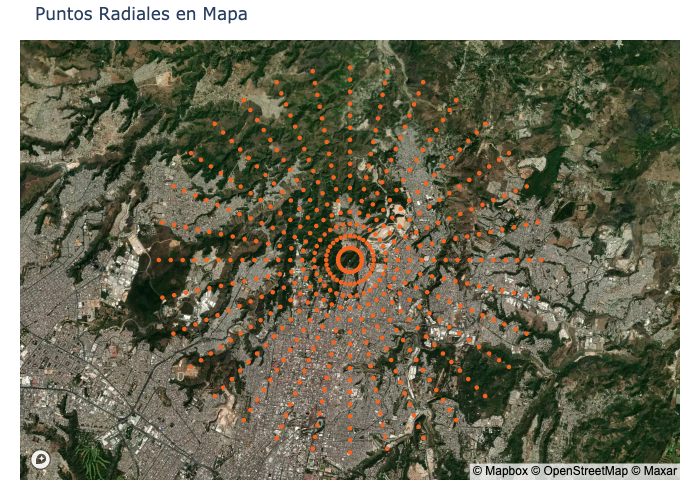

In [15]:
#Preparando para mapa
puntos_aplanados = [punto for linea in puntos for punto in linea]
# Separar las latitudes y longitudes
lats = [punto[0] for punto in puntos_aplanados]
lons = [punto[1] for punto in puntos_aplanados]

# Crear el mapa
fig = go.Figure(go.Scattermapbox(
    lon = lons,
    lat = lats,
    mode = 'markers',
    marker = dict(size = 5, color = sClr1)
))

fig.update_layout(
    title = 'Puntos Radiales en Mapa',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        style='mapbox://styles/mapbox/satellite-v9',  # Opciones de mapa en documentación de mapbox
                center=go.layout.mapbox.Center(
            lat=sample_gw['latitude'],
            lon=sample_gw['longitude']
        ),
        zoom = 11.5
    ),
)
fig.update_layout(margin={"r":20,"t":40,"l":20,"b":20},)
fig.show("png")

In [16]:
def getHeigths(proveDic):
    lat = proveDic['latitude']
    lon = proveDic['longitude']
    distancia_km = proveDic['rDist']
    num_puntos = proveDic['linePoints']
    #angulos = [0, 45, 90, 135, 180, 225, 270, 315]
    todos_los_puntos = []

    for angulo in angulos:
        puntos_linea = []
        for i in range(int(num_puntos)):
            # Calculando distancia para el punto actual
            distancia_actual = distancia_km * (i / float(num_puntos) - 1)
            # Calculando el nuevo punto
            punto = geodesic(kilometers=distancia_actual).destination((lat, lon),  angulo)
            puntos_linea.append((punto.latitude, punto.longitude))
        todos_los_puntos.append(puntos_linea)
    puntos_aplanados = [punto for linea in todos_los_puntos for punto in linea]
    puntos_aplanados = [[round(i[0],8), round(i[1],8)] for i in puntos_aplanados]
    elev, res = getElevation(puntos_aplanados)
    return elev, puntos_aplanados


In [17]:
result = getHeigths(sample_gw)
#result

In [18]:
columns = ['latitude1','longitude1','latitude2','longitude2']
elevation_columns = [f'e{i}' for i in range(1, linePoints+1)]
np.array(result[0]).reshape(rLines, linePoints)
elev_df = pd.DataFrame(np.array(result[0]).reshape(rLines, linePoints), columns = elevation_columns)
elev_df

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16
0,1490.774780,1490.191162,1488.752808,1488.637451,1474.598145,1487.228516,1487.906250,1465.254639,1482.878174,1480.824341,1480.038086,1477.287720,1468.886475,1463.288696,1470.080200,1463.974854
1,1491.586548,1486.484985,1468.717773,1495.178101,1493.109619,1491.843628,1490.242432,1488.582520,1487.023926,1486.831787,1483.961914,1476.588501,1478.915649,1476.158081,1470.649536,1468.926392
2,1515.966431,1525.632812,1516.573853,1508.422852,1506.780273,1503.449585,1502.524048,1498.799805,1496.107910,1491.504883,1485.589233,1480.106079,1471.614624,1469.891113,1467.348755,1471.563843
3,1519.841797,1518.062988,1516.218140,1508.209473,1505.145874,1511.450317,1509.401733,1503.684692,1499.012573,1496.306274,1490.470947,1485.316895,1481.365234,1468.689575,1456.484863,1445.416504
4,1504.758911,1402.055420,1499.744263,1472.855591,1484.023438,1492.315186,1495.223389,1507.136475,1501.689087,1492.889526,1492.482544,1468.661011,1480.741333,1477.059082,1472.765259,1406.671875
5,1525.424072,1506.966187,1423.226440,1470.015747,1440.159790,1362.086304,1397.665894,1437.544189,1465.699585,1480.436890,1492.231812,1485.535889,1479.488159,1479.276367,1476.110962,1445.079712
6,1503.032349,1485.553345,1521.381592,1437.248413,1476.806519,1499.646240,1477.290161,1473.143311,1346.648804,1372.260620,1359.865601,1478.603394,1469.365967,1476.146118,1471.917114,1452.124512
7,1576.048096,1548.942993,1512.948975,1504.063965,1498.955200,1475.228760,1478.617188,1481.713501,1475.803101,1453.098633,1354.374390,1466.485840,1467.633911,1420.190063,1475.565674,1474.930054
8,1521.725952,1492.787842,1502.187134,1490.100098,1487.509644,1487.188354,1445.045898,1476.996704,1452.561035,1436.665527,1355.861694,1407.091919,1464.497681,1454.281860,1455.022461,1469.318481
9,1507.223755,1494.696899,1480.570923,1481.411011,1471.073364,1402.131348,1437.561401,1473.916260,1390.499146,1444.017212,1355.824463,1383.520752,1462.516235,1441.914062,1391.116089,1470.052612


In [19]:
t_catcher = np.array(result[1]).reshape(rLines, linePoints,2)

In [20]:
coords = t_catcher.shape

In [21]:
coords_names = ['latitude','longitude','latitude_neighbor','longitude_neighbor']
limit_coords = t_catcher[:,[0,-1],:]
limit_coords.reshape(rLines,4)
limit_coords_df = pd.DataFrame(limit_coords.reshape(rLines,4), columns = coords_names)
limit_coords_df.head()

,latitude,longitude,latitude_neighbor,longitude_neighbor
0,14.618898,-90.502968,14.661263,-90.502968
1,14.619766,-90.512022,14.661317,-90.503534
2,14.622337,-90.520728,14.661478,-90.504078
3,14.626512,-90.528752,14.661739,-90.504580
4,14.632131,-90.535786,14.662090,-90.505019


In [22]:
last_df = pd.concat([limit_coords_df, elev_df], axis = 1)
last_df.head()

,latitude,longitude,latitude_neighbor,longitude_neighbor,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16
0,14.618898,-90.502968,14.661263,-90.502968,1490.774780,1490.191162,1488.752808,1488.637451,1474.598145,1487.228516,1487.906250,1465.254639,1482.878174,1480.824341,1480.038086,1477.287720,1468.886475,1463.288696,1470.080200,1463.974854
1,14.619766,-90.512022,14.661317,-90.503534,1491.586548,1486.484985,1468.717773,1495.178101,1493.109619,1491.843628,1490.242432,1488.582520,1487.023926,1486.831787,1483.961914,1476.588501,1478.915649,1476.158081,1470.649536,1468.926392
2,14.622337,-90.520728,14.661478,-90.504078,1515.966431,1525.632812,1516.573853,1508.422852,1506.780273,1503.449585,1502.524048,1498.799805,1496.107910,1491.504883,1485.589233,1480.106079,1471.614624,1469.891113,1467.348755,1471.563843
3,14.626512,-90.528752,14.661739,-90.504580,1519.841797,1518.062988,1516.218140,1508.209473,1505.145874,1511.450317,1509.401733,1503.684692,1499.012573,1496.306274,1490.470947,1485.316895,1481.365234,1468.689575,1456.484863,1445.416504
4,14.632131,-90.535786,14.662090,-90.505019,1504.758911,1402.055420,1499.744263,1472.855591,1484.023438,1492.315186,1495.223389,1507.136475,1501.689087,1492.889526,1492.482544,1468.661011,1480.741333,1477.059082,1472.765259,1406.671875


In [23]:
#Altura de prueba
h_prove = 3
last_df['h'] = sample_gw['h']
last_df['h_neighbor'] = h_prove

In [24]:
#Calculando obstrucción de la zona de Fresnel
fresnel_names = [f'f{i}' for i in range(1, linePoints+1)]
catcher = last_df.apply(lambda x: fresnelAnalysis3(x,linePoints,915000000), axis=1).apply(pd.Series)
catcher.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.22,0.32,0.41,0.07,0.49,0.56,0.04,0.54,0.54,0.58,0.56,0.36,0.21,0.55,0.0
1,0.0,0.00,0.00,0.56,0.55,0.56,0.56,0.56,0.57,0.61,0.59,0.43,0.55,0.53,0.34,0.0
2,0.0,0.80,0.50,0.35,0.41,0.41,0.47,0.46,0.47,0.44,0.36,0.29,0.10,0.08,0.00,0.0
3,0.0,0.32,0.49,0.41,0.48,0.79,0.86,0.84,0.86,0.93,0.93,0.96,1.00,0.87,0.65,0.0
4,0.0,0.00,0.56,0.00,0.49,0.89,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.0


In [25]:
all_obstruction = catcher.values.flatten()

In [26]:
np.array(result[1]).shape

(512, 2)

In [27]:
heuristic_df = pd.DataFrame(np.array(result[1]), columns = ['latitude','longitude'])
heuristic_df['obstruction'] = all_obstruction
heuristic_df.head()

,latitude,longitude,obstruction
0,14.618898,-90.502968,0.00
1,14.621722,-90.502968,0.22
2,14.624546,-90.502968,0.32
3,14.627371,-90.502968,0.41
4,14.630195,-90.502968,0.07


In [28]:
temp_color_map = plt.get_cmap('nr-d')
num_samples = 256
color_scale = [
    (i / (num_samples - 1), 
    matplotlib.colors.rgb2hex(temp_color_map(i / (num_samples - 1))))
    for i in range(num_samples)
]

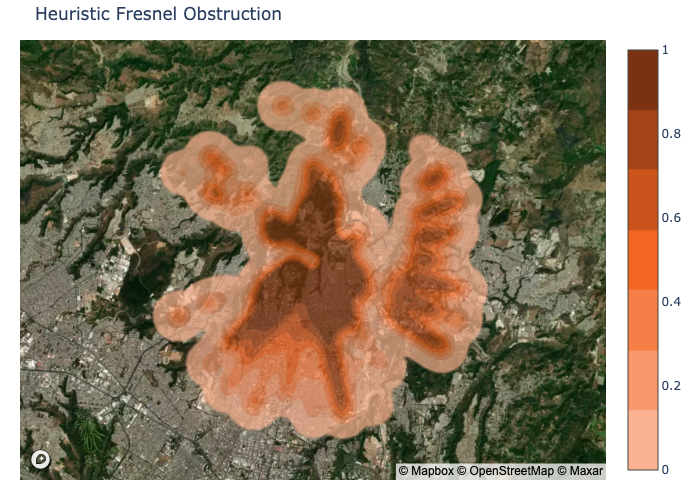

In [29]:
#Graficando obstrucción de la zona de Fresnel
fig = go.Figure(go.Densitymapbox(lat=heuristic_df.latitude, lon=heuristic_df.longitude, z=heuristic_df.obstruction,
                                 radius=25, opacity = 0.7, colorscale = color_scale, zmin = 0, zmax = 1))
fig.update_layout(mapbox_style="open-street-map", title = 'Heuristic Fresnel Obstruction')
fig.update_layout(margin={"r":20,"t":40,"l":20,"b":20},)
#Centrando
fig.update_layout(mapbox = dict(accesstoken=mapbox_access_token, style='mapbox://styles/mapbox/satellite-v9',\
                                center = dict(lat = sample_gw['latitude'], lon = sample_gw['longitude']), zoom = 11.3))
fig.show("png")

In [30]:
#Invirtiendo zona de Fresnel
heuristic_df['line_of_sight'] = 1 - heuristic_df['obstruction']


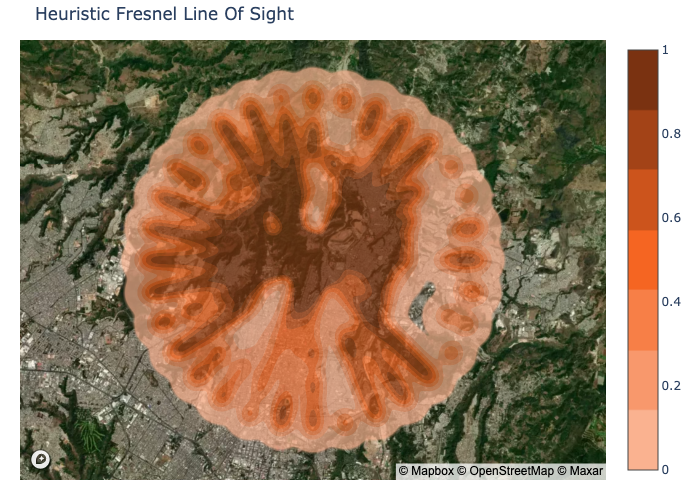

In [31]:
#Graficando mapa
fig = go.Figure(go.Densitymapbox(lat=heuristic_df.latitude, lon=heuristic_df.longitude, z=heuristic_df.line_of_sight,
                                 radius=25, opacity = 0.7, colorscale = color_scale, zmin = 0, zmax = 1))
fig.update_layout(mapbox_style="open-street-map", title = 'Heuristic Fresnel Line Of Sight')
fig.update_layout(margin={"r":20,"t":40,"l":20,"b":20},)
fig.update_layout(mapbox = dict(accesstoken=mapbox_access_token, style='mapbox://styles/mapbox/satellite-v9',\
                  center = dict(lat = sample_gw['latitude'], lon = sample_gw['longitude']), zoom = 11.3))
fig.show("png")